In [ ]:
!pip install ucimlrepo

In [ ]:
import os          #funciones para interactuar con el sistema operativo
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo #Nos deja acceder a un repositorio de datasets de UCI Machine Learning Repository para descargar datos

import yaml #archivos en formato YAML


import matplotlib.pyplot as plt
import seaborn as sns

# Librerias para preprocesamiento e ing de caracteristicas
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer, power_transform

# Librerias para la canalizacion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearnPipeline

# Librerias para la regresion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn import metrics

from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score

In [ ]:
class DataExplorer:
    @staticmethod
    def explore_data(data):
        print('\nHEADER\n--------------------------------------------------------------------------------------------------------------------------------------------')
        print(data.head().T)
        print('\n\nDATA DESCRIPTION\n--------------------------------------------------------------------------------------------------------------------------------------------')
        print(data.describe().T)
        print('\n\nDATA INFORMATION\n--------------------------------------------------------------------------------------------------------------------------------------------')
        print(data.info())
        print('\n\nDATA FREQUENCY\n--------------------------------------------------------------------------------------------------------------------------------------------')
        print(data.nunique())

    @staticmethod
    def plot_categorical_distributions(data, columns, target):
        figure, axes = plt.subplots(7,5, figsize = (20,28))
        axes = axes.ravel()

        for col, ax in zip(columns, axes):
            sns.countplot(x = data[col], hue = target, ax = ax, palette = 'bright')
            ax.set(title = f'{col}', xlabel = None)

    @staticmethod
    def plot_correlation_matrix(X_data, y_data):
        data = X_data.join(y_data)
        corr_matrix = data.corr(method = 'pearson', numeric_only = True)
        plt.figure(figsize=(17, 10))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Pearson correlation matrix')
        plt.show()


In [ ]:
class StudentPerformanceModel:
    def __init__(self, dataset_id):
        self.dataset_id = dataset_id #declarando atributo
        self.data = None #dataframe de def load_data
        self.X_train, self.X_test, self.y_train, self.y_test = [None, None, None, None] #[None] * 4
        self.pipeline = None #def build_pipeline

    def load_data(self):
        fetched_data = fetch_ucirepo(id=self.dataset_id)
        self.data = pd.concat([fetched_data.data.features, fetched_data.data.targets], axis=1)

        column_names = ['Student Age', 'Sex', 'Graduated High-school Type', 'Scholarship Type', 'Additional Work',
                        'Regular Artistic/Sports Activity', 'Do you have a Partner', 'Total Salary', 'Transportation',
                        'Accommodation in Cyprus', 'Mothers Education', 'Fathers Education', 'Number of Siblings',
                        'Parental Status', 'Mothers Occupation', 'Fathers Occupation', 'Weekly Study Hours',
                        'Reading Frequency (Non-Scientific)', 'Reading Frequency (Scientific)', 'Attendance to Seminars',
                        'Impact on Success', 'Attendance to Classes', 'Preparation to Midterm 1', 'Preparation to Midterm 2',
                        'Taking Notes in Classes', 'Listening in Classes', 'Discussion Improves Success', 'Flip-Classroom',
                        'Cumulative GPA Last Semester', 'Expected GPA at Graduation', 'COURSE ID', 'OUTPUT Grade']
        self.data.columns = column_names

        return self

    def preprocess_data(self):
        # Definimos X e y
        self.X = self.data.drop('OUTPUT Grade', axis=1)
        self.y = self.data['OUTPUT Grade']

        # Dividimos en conjuntos de entrenamiento y prueba
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, stratify=self.y, random_state=0)

        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(self.X_test, self.y_test, test_size=0.5, stratify=self.y_test, random_state=1)

        print("Division de datos completada")
        print("")
        print("Conjunto de entrenamiento:", self.X_train.shape, self.y_train.shape)
        print("Conjunto de validacion:", self.X_val.shape, self.y_val.shape)
        print("Conjunto de prueba:", self.X_test.shape, self.y_test.shape)
        return self

    def encode_target(self):
        # Codificando la variable objetivo (OUTPUT Grade)
        self.label_encoder = LabelEncoder()
        self.y_train = self.label_encoder.fit_transform(self.y_train)
        self.y_val = self.label_encoder.transform(self.y_val)
        self.y_test = self.label_encoder.transform(self.y_test)
        return self

    def build_pipeline(self):
        # Variables categoricas
        catNOM_pipeline = Pipeline(steps=[('OneHot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])
        catORD_pipeline = Pipeline(steps=[('Ordinal', OrdinalEncoder())])

        catNOM_pipeline_nombres = ['Sex', 'Graduated High-school Type',
                'Scholarship Type', 'Additional Work', 'Regular Artistic/Sports Activity',
                'Do you have a Partner',  'Transportation',
                'Accommodation in Cyprus', 'Mothers Education', 'Fathers Education',
                 'Parental Status', 'Mothers Occupation',
                'Fathers Occupation',  'Attendance to Seminars', 'Impact on Success',
                'Attendance to Classes', 'Preparation to Midterm 1', 'Preparation to Midterm 2',
                'Taking Notes in Classes', 'Listening in Classes',
                'Discussion Improves Success', 'Flip-Classroom',
                ]
        catORD_pipeline_nombres = ['Student Age', 'Number of Siblings', 'Total Salary', 'Weekly Study Hours', 'Reading Frequency (Non-Scientific)',
                                   'Reading Frequency (Scientific)', 'Cumulative GPA Last Semester', 'Expected GPA at Graduation','Student Age',
                                   'Number of Siblings']

        # Combinar las transformaciones en un ColumnTransformer
        self.pipeline = ColumnTransformer(transformers=[
            ('OHE', catNOM_pipeline, catNOM_pipeline_nombres),
            ('Ordinal', catORD_pipeline, catORD_pipeline_nombres)
        ])
        return self

    def apply_pipeline(self):
        # Aplicando el pipeline al conjunto de train, val y test
        self.X_train = self.pipeline.fit_transform(self.X_train) #Ajustamos y transformamos solo con el conjunto de entrenamiento
        self.X_val = self.pipeline.transform(self.X_val)
        self.X_test = self.pipeline.transform(self.X_test)
        return self

    def train_model_knn(self, n_neighbors=5):
        # Modelo KNN
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm = 'ball_tree', metric = 'manhattan', weights = 'distance')
        self.model.fit(self.X_train, self.y_train)
        return self

    def train_model_dtree(self, max_depth=None, min_samples_split=2):
        # Árbol de decisión
        self.model = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
        self.model.fit(self.X_train, self.y_train)
        return self

    def train_model_rf(self, n_estimators=100, max_depth=None):
      # Bosque Aleatorio
        self.model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
        self.model.fit(self.X_train, self.y_train)
        return self

    def evaluate_model(self, evaluation_set="validation"):
        # Elegir el conjunto de validacion o prueba
        if evaluation_set == "validation":
            X_temp = self.X_val
            y_temp = self.y_val
        else:
            X_temp = self.X_test
            y_temp = self.y_test

        # Evaluar el modelo en el conjunto que se seleccione, y_pred = etiquetas = vector
        y_pred = self.model.predict(X_temp)#X_val
        print(f'\n\nEvaluation of {evaluation_set} set\n')
        cm = confusion_matrix(y_temp, y_pred)#y_val, comparamos predicciones vs etiquetas verdaderas
        ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues') #Tabla anterior graficada
        plt.show()
                                    #y_val
        print(classification_report(y_temp, y_pred))
        return self

    def cross_validate_model(self):
        # Validacion cruzada
        scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5)
        print(f"Accuracy con validacion cruzada del conjunto de entrenamiento: {np.mean(scores):.4f}")#calculamos el promedio el accuracy de los 5 folders
        return self

Division de datos completada

Conjunto de entrenamiento: (101, 31) (101,)
Conjunto de validacion: (22, 31) (22,)
Conjunto de prueba: (22, 31) (22,)

HEADER
--------------------------------------------------------------------------------------------------------------------------------------------
                                    0  1  2  3  4
Student Age                         2  2  2  1  2
Sex                                 2  2  2  1  2
Graduated High-school Type          3  3  2  1  1
Scholarship Type                    3  3  3  3  3
Additional Work                     1  1  2  1  2
Regular Artistic/Sports Activity    2  2  2  2  2
Do you have a Partner               2  2  2  1  1
Total Salary                        1  1  2  2  3
Transportation                      1  1  4  1  1
Accommodation in Cyprus             1  1  2  2  4
Mothers Education                   1  2  2  1  3
Fathers Education                   2  3  2  2  3
Number of Siblings                  3  2  2  5  2
Par

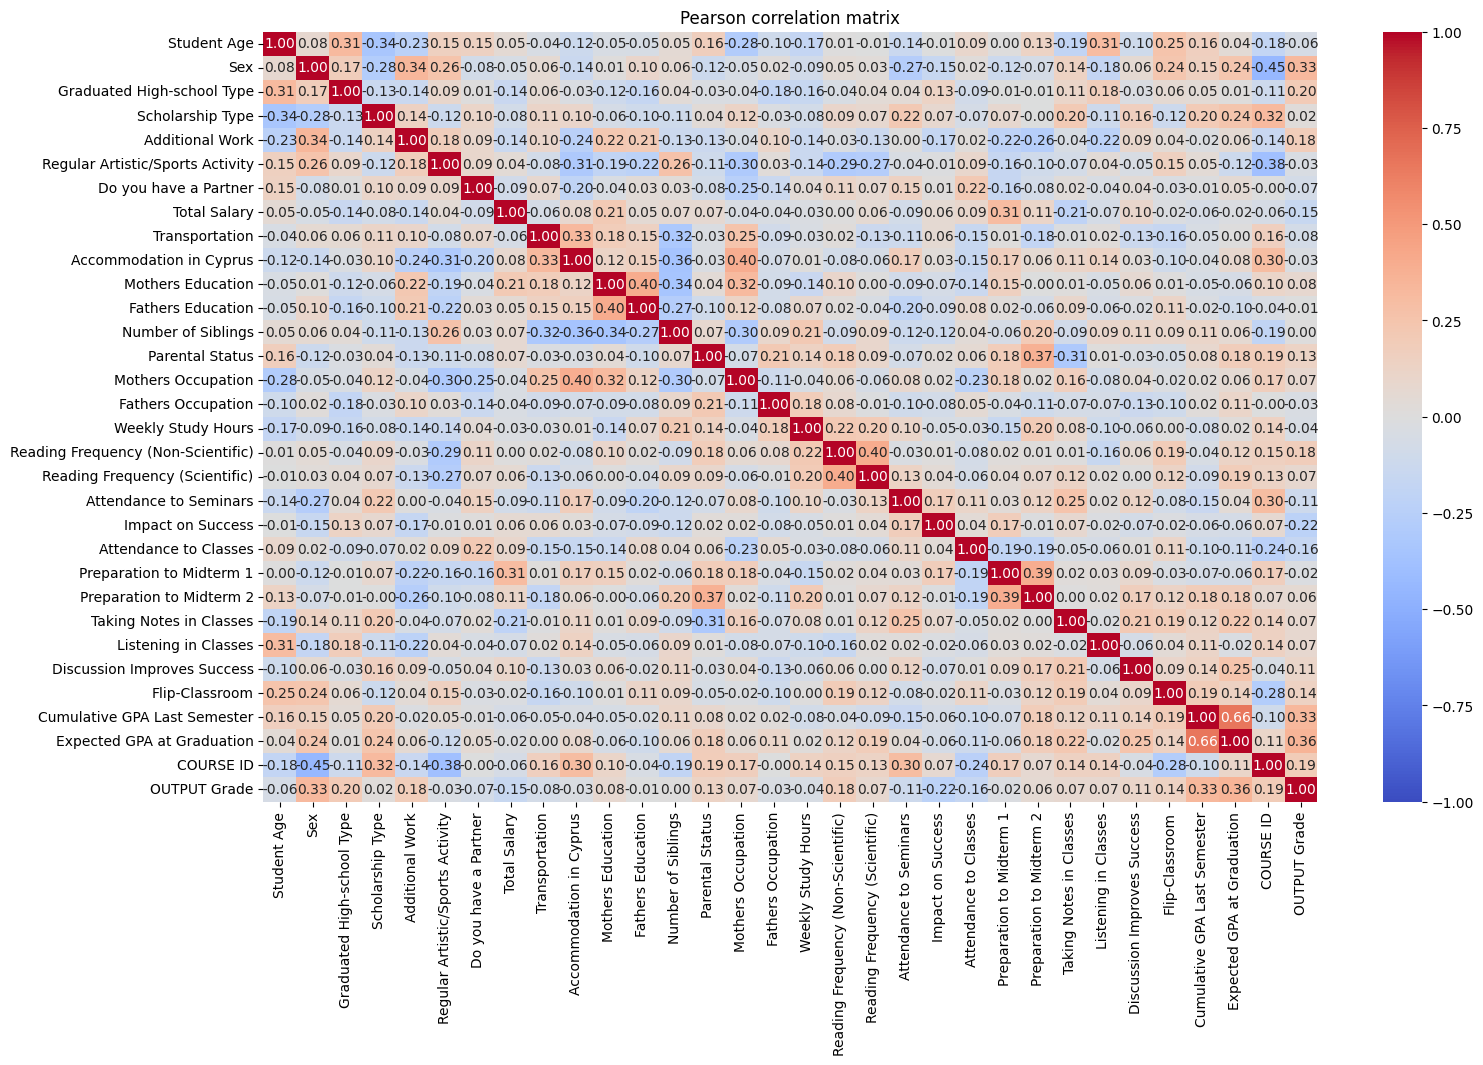

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


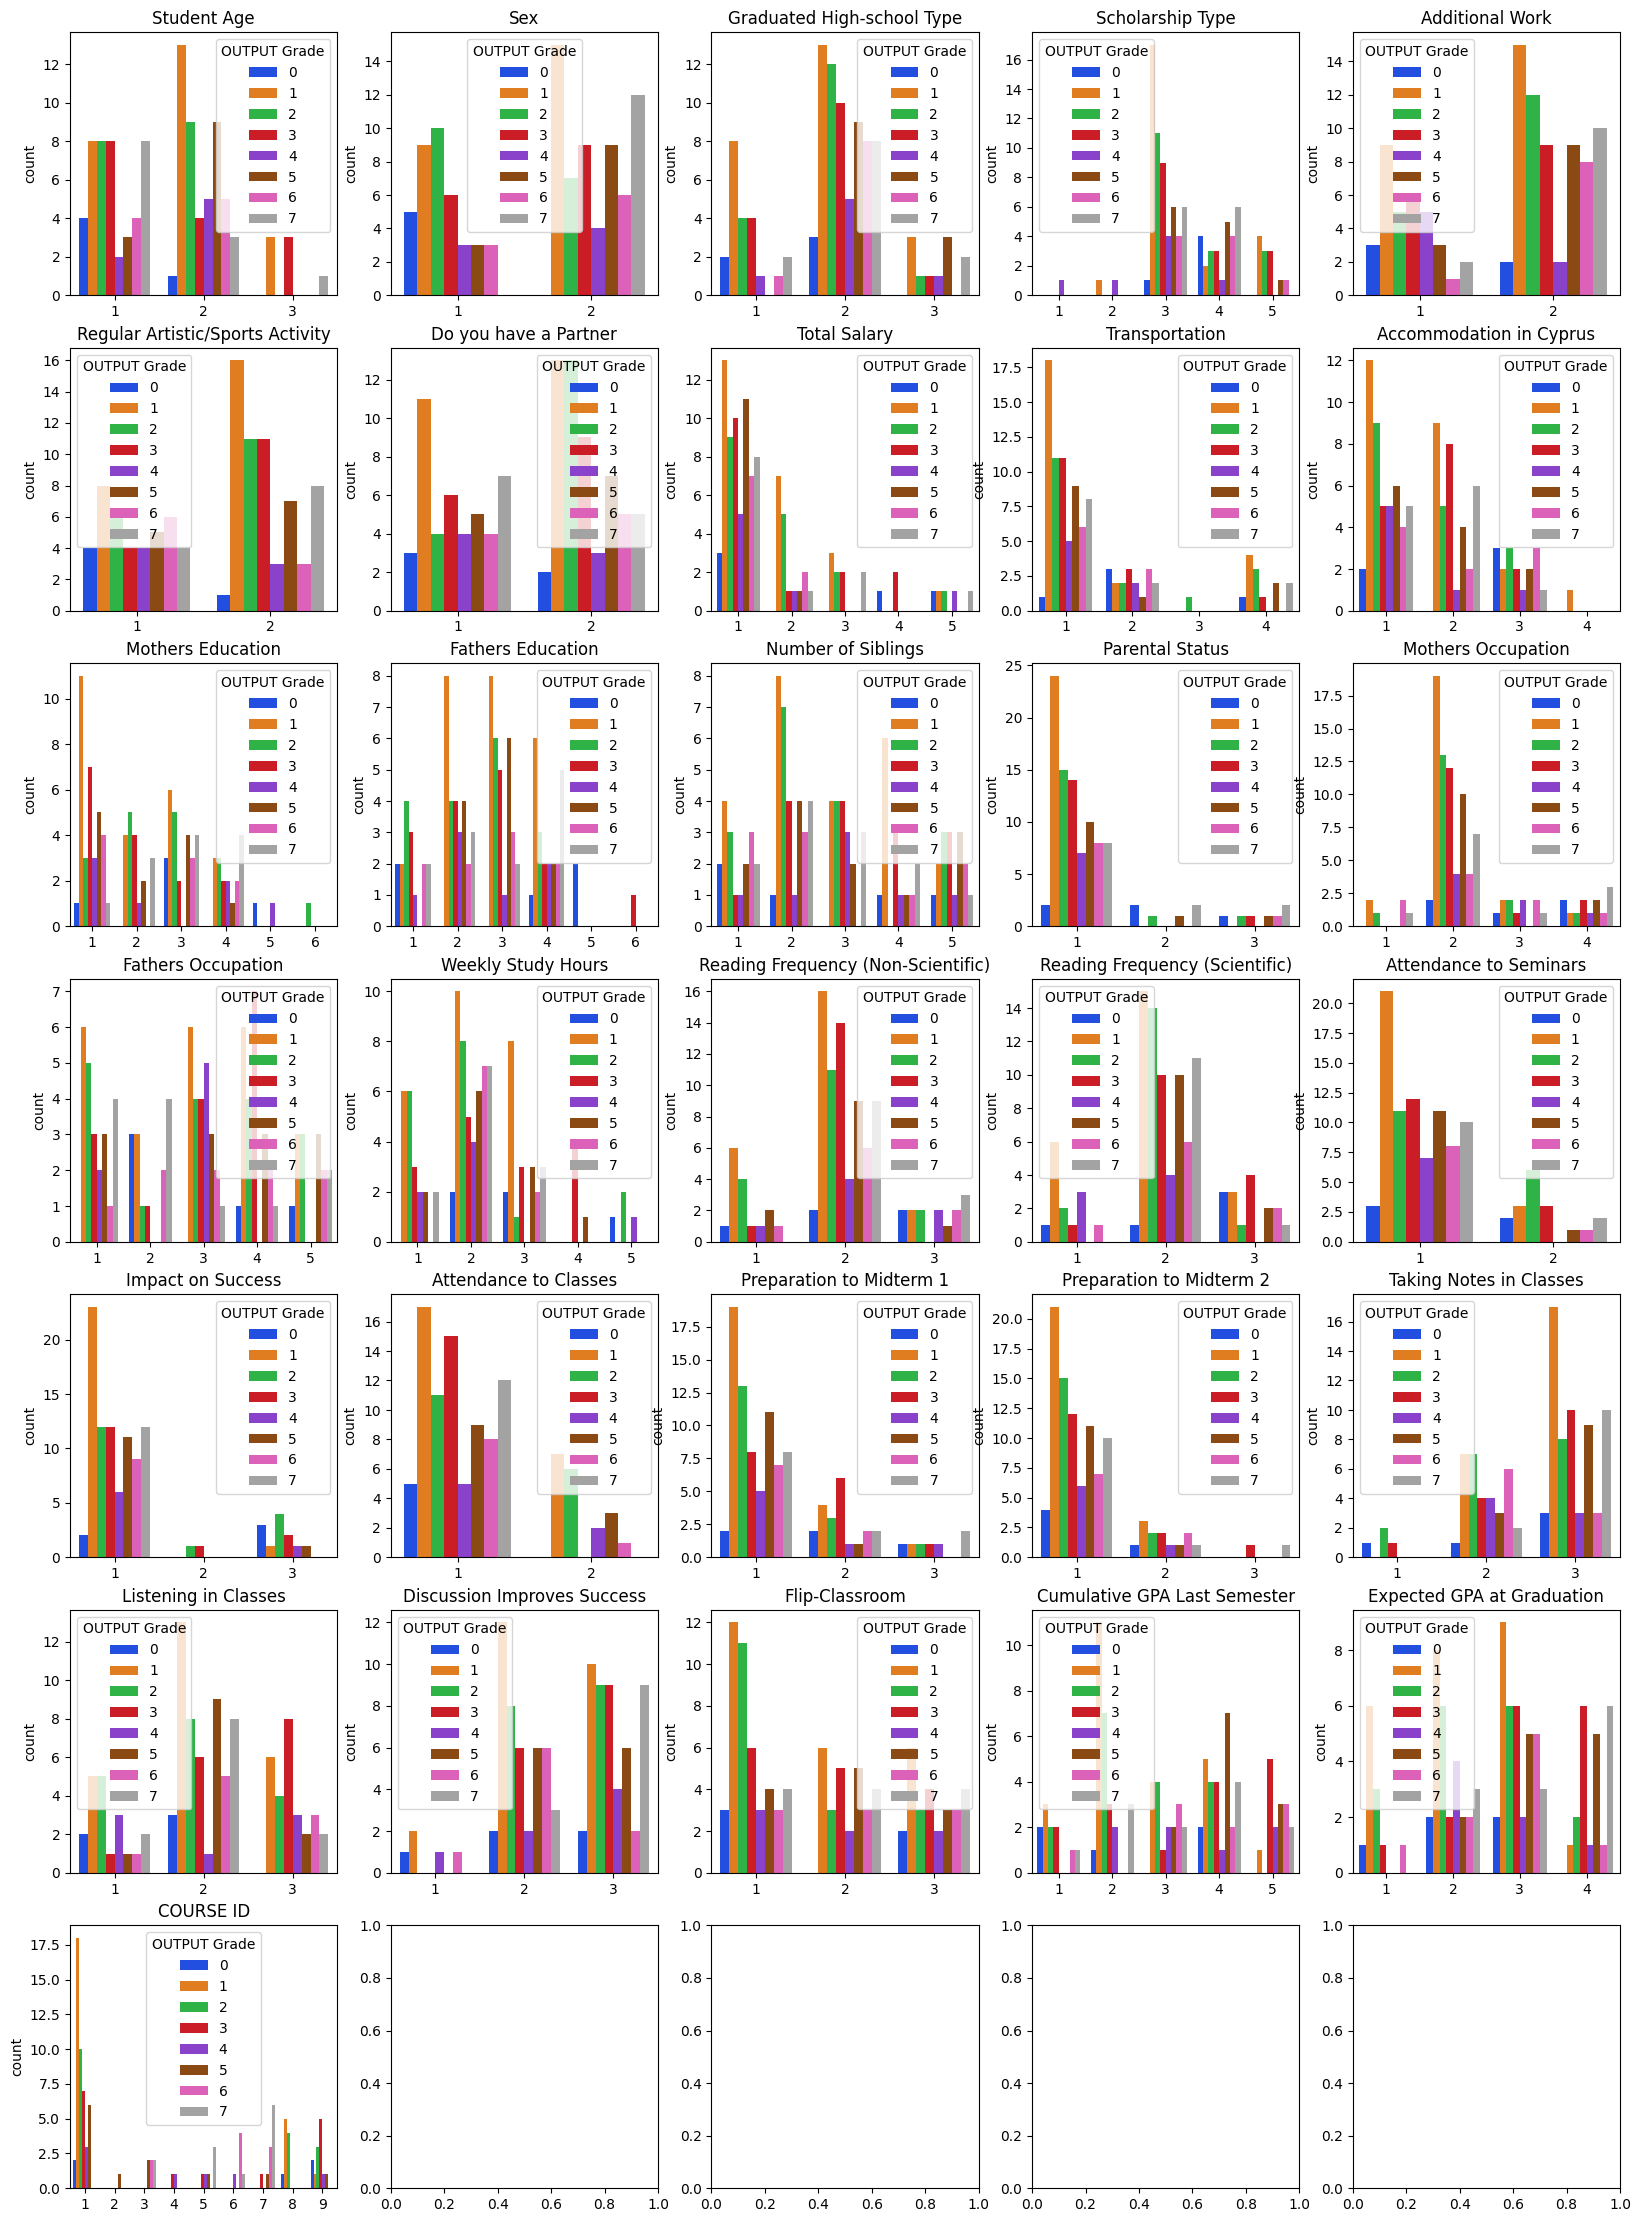

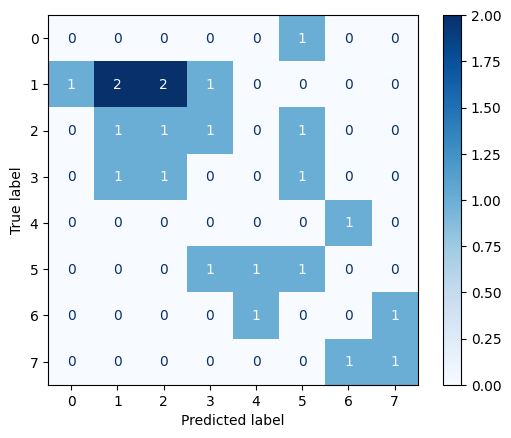

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.33      0.40         6
           2       0.25      0.25      0.25         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.25      0.33      0.29         3
           6       0.00      0.00      0.00         2
           7       0.50      0.50      0.50         2

    accuracy                           0.23        22
   macro avg       0.19      0.18      0.18        22
weighted avg       0.26      0.23      0.24        22

Accuracy con validacion cruzada del conjunto de entrenamiento: 0.1086


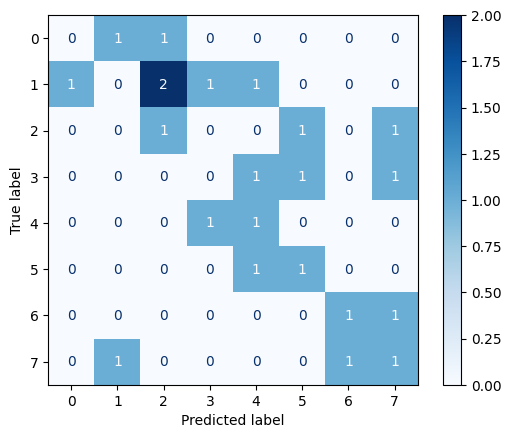

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         5
           2       0.25      0.33      0.29         3
           3       0.00      0.00      0.00         3
           4       0.25      0.50      0.33         2
           5       0.33      0.50      0.40         2
           6       0.50      0.50      0.50         2
           7       0.25      0.33      0.29         3

    accuracy                           0.23        22
   macro avg       0.20      0.27      0.23        22
weighted avg       0.17      0.23      0.19        22



In [ ]:
model = StudentPerformanceModel(dataset_id=856)
model.load_data()
model.preprocess_data()

# EDA
DataExplorer.explore_data(model.data) # def explore_data(data):
DataExplorer.plot_correlation_matrix(model.X_train, model.y_train) # def plot_correlation_matrix(X_data, y_data):
DataExplorer.plot_categorical_distributions(model.X_train, model.data.columns[:-1], model.y_train) # def plot_categorical_distributions(data, columns, target)

# Modelling and processing
model.encode_target().build_pipeline().apply_pipeline().train_model_dtree().evaluate_model().cross_validate_model().evaluate_model("test")